In [ ]:
!pip install stable-baselines3[extra]
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 9.4 MB/s eta 0:00:00:00:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 30.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.6 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=d44b55f980406facdf6b5fbcdde0687d4236362dc59823c2ed62aec047a62f5b
  Stored in directory: /root/.cache/pip/wheels/f2/56/c8/15764130eda5e4d3b867b7c86b70846aa56dde22083cf34a5f
Successfully built AutoROM.accept-rom-license
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.2 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━

In [ ]:
import os
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

import imageio
from PIL import Image
import PIL.ImageDraw as ImageDraw

from IPython.display import display, Markdown

from stable_baselines3 import PPO

from stable_baselines3.common import results_plotter
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import ts2xy
from stable_baselines3.common.monitor import load_results

import gym
import gymnasium as gym

/opt/conda/lib/python3.7/site-packages/botocore/httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext


In [ ]:
def agent_eval(agent, n_eval_episodes=25, seed=42, verbose=1):
    eval_env = make_vec_env("LunarLander-v2", n_envs=16, seed=seed)
    reward_length = evaluate_policy(agent, eval_env,
                           return_episode_rewards=True,
                           n_eval_episodes=n_eval_episodes,
                           deterministic=True)
    for i, p in enumerate(["mean", "length"]):
        mean = np.mean(reward_length[i])
        if verbose:
            sem = st.sem(reward_length[i])
            mean_CI = st.t.interval(0.95, df=len(reward_length[i])-1, loc=mean, scale=sem)

            print(f"mean_{p}={mean:.3f}, SEM={sem}, CI=[{mean_CI[0]:.3f}:{mean_CI[1]:.3f}]")

    return np.mean(reward_length[0])

In [ ]:
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    fig = plt.figure(title, figsize=(10, 5))
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    min_x, max_x = min(x), max(x)
    plt.scatter(x, y, s=1)
    y = moving_average(y, window=100)
    # Truncate x
    x = x[len(x) - len(y):]

    plt.plot(x, y, color="black")
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " (Smoothed)")
    plt.xlim(min_x, max_x)
    plt.show()

class SaveOnBestTrainingRewardCallback(BaseCallback):

    def __init__(self, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf
        self.done_eps = 0

    def _check(self):
        results = load_results(self.log_dir)
        new_eps = len(results) - self.done_eps
        self.done_eps = len(results)
        x, y = ts2xy(results, 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-new_eps:])
            if mean_reward > self.best_mean_reward:
                self.best_mean_reward = mean_reward
                if self.verbose > 0:
                    print(f"New best mean reward: {mean_reward:.2f}, eval_episodes: {new_eps}, total_steps: {self.num_timesteps}, total_episodes: {self.done_eps}")
                    self.model.save(self.save_path)

    def _init_callback(self) -> None:
        if self.log_dir is not None:
            os.makedirs(self.log_dir, exist_ok=True)

    def _on_step(self) -> bool:
        # if self.n_calls % self.check_freq == 0:
        #   self._check()
        return True

    def _on_training_end(self) -> None:
        interim_mean = agent_eval(self.model.load(self.save_path), verbose=0)
        final_mean = agent_eval(self.model, verbose=0)

        if interim_mean > final_mean:
            print(f"Interim model was better.")
            self.model.set_parameters(self.save_path)

        self.model.save(self.log_dir)

    def _on_rollout_end(self) -> None:
        self._check()

In [ ]:
def _save_frames_as_gif(frames, path="./", filename="gym_animation.gif", fps=60):
    imageio.mimwrite(os.path.join(path, filename), frames, fps=fps)

def _add_text_info(frame, episode_num, step, reward):
    im = Image.fromarray(frame)
    drawer = ImageDraw.Draw(im)
    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    drawer.text((im.size[0]/20,im.size[1]/18),
                f"Episode: {episode_num+1}\nStep: {step}\nCurrent reward: {reward}",
                fill=text_color)
    return im

def save_trained_agent_gif(agent, path="./", filename="trained_agent.gif", n=1, fps=60):
    env = gym.make("LunarLander-v2", render_mode="rgb_array")

    frames = []
    for i in range(n):
        R = 0
        observation, _ = env.reset()
        for t in range(500):
            action, _ = agent.predict(observation, None, None, True)
            observation, reward, terminated, _, _ = env.step(action)
            R += reward
            frame = env.render()
            frames.append(_add_text_info(frame, episode_num=i, step=t, reward=R))
            if terminated:
                frames.extend([_add_text_info(frame, episode_num=i, step=t, reward=R)]*25)
                break

    env.close()

    _save_frames_as_gif(frames, path=path, filename=filename, fps=fps)

### PPO Baseline (Proximal Policy Optimization)
##### First try

In [ ]:
model_dir = "../models/01_LunarLander/ppo-LunarLander-v2_baseline"

env = make_vec_env("LunarLander-v2", n_envs=16, monitor_dir=model_dir, env_kwargs={'enable_wind': True})

In [ ]:

model = PPO("MlpPolicy", env, verbose=0, tensorboard_log="../tb_logs/")
callback = SaveOnBestTrainingRewardCallback(log_dir=model_dir)

model.learn(total_timesteps=int(500_000), callback=callback, tb_log_name="first_run_2m")

New best mean reward: -182.58, eval_episodes: 339, total_steps: 32768, total_episodes: 339
New best mean reward: -133.03, eval_episodes: 347, total_steps: 65536, total_episodes: 686
New best mean reward: -106.83, eval_episodes: 328, total_steps: 98304, total_episodes: 1014
New best mean reward: -72.25, eval_episodes: 311, total_steps: 131072, total_episodes: 1325
New best mean reward: -49.67, eval_episodes: 265, total_steps: 163840, total_episodes: 1590
New best mean reward: -26.18, eval_episodes: 222, total_steps: 196608, total_episodes: 1812
New best mean reward: -22.34, eval_episodes: 119, total_steps: 229376, total_episodes: 1931
New best mean reward: -16.29, eval_episodes: 70, total_steps: 262144, total_episodes: 2001
New best mean reward: 47.07, eval_episodes: 46, total_steps: 294912, total_episodes: 2047
New best mean reward: 61.06, eval_episodes: 37, total_steps: 327680, total_episodes: 2084
New best mean reward: 61.57, eval_episodes: 38, total_steps: 360448, total_episodes: 21

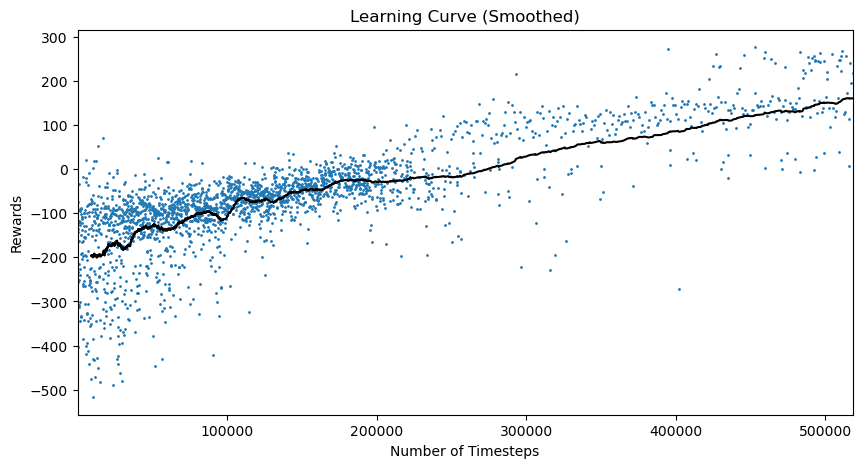

In [ ]:
# results_plotter.plot_results([model_dir], None, results_plotter.X_TIMESTEPS, "PPO LunarLander", figsize=(10,5))
plot_results(model_dir)

In [ ]:
agent_eval(model);

mean_mean=191.497, SEM=20.344291119672683, CI=[149.508:233.485]
mean_length=413.040, SEM=25.686538627589876, CI=[360.026:466.054]


In [ ]:
save_trained_agent_gif(model, filename="ppo_baseline.gif", n=5, fps=60)
display(Markdown(f"<img src='ppo_baseline.gif'>"))

<img src='ppo_baseline.gif'>

## Change hyperparameters

### Clipped Surrogate Objective = 0.2

New best mean reward: -184.01, eval_episodes: 84, total_steps: 8192, total_episodes: 84
New best mean reward: -150.99, eval_episodes: 90, total_steps: 16384, total_episodes: 174
New best mean reward: -148.75, eval_episodes: 65, total_steps: 40960, total_episodes: 399
New best mean reward: -132.91, eval_episodes: 66, total_steps: 49152, total_episodes: 465
New best mean reward: -112.66, eval_episodes: 65, total_steps: 57344, total_episodes: 530
New best mean reward: -90.62, eval_episodes: 52, total_steps: 73728, total_episodes: 629
New best mean reward: -83.95, eval_episodes: 39, total_steps: 90112, total_episodes: 713
New best mean reward: -72.51, eval_episodes: 29, total_steps: 98304, total_episodes: 742
New best mean reward: -66.72, eval_episodes: 22, total_steps: 114688, total_episodes: 781
New best mean reward: -27.39, eval_episodes: 15, total_steps: 131072, total_episodes: 813
New best mean reward: 4.09, eval_episodes: 10, total_steps: 139264, total_episodes: 823
New best mean rew

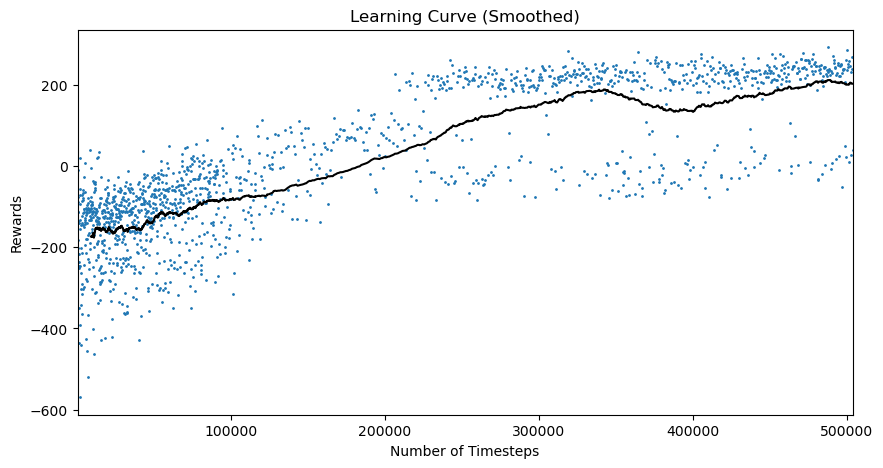

In [ ]:
model_dir = "../models/01_LunarLander/ppo-LunarLander-v2/"

env = make_vec_env("LunarLander-v2", n_envs=16, monitor_dir=model_dir)
model = PPO(
    policy="MlpPolicy",
    env=env,
    n_steps=512,
    batch_size=64,
    n_epochs=5,
    clip_range=0.2, # Clipped Surrogate Objective
    verbose=0,
    tensorboard_log="../tb_logs/"
)
callback = SaveOnBestTrainingRewardCallback(log_dir=model_dir)

model.learn(total_timesteps=500_000, callback=callback, tb_log_name="v2_2m")
plot_results(model_dir)

In [ ]:
agent_eval(model);

mean_mean=215.769, SEM=10.841020355304153, CI=[193.394:238.144]
mean_length=432.720, SEM=13.524856129857104, CI=[404.806:460.634]


In [ ]:
save_trained_agent_gif(model, filename="ppo_v2.gif", n=5, fps=60)
display(Markdown(f"<img src='ppo_v2.gif'>"))

<img src='ppo_v2.gif'>

### Fixed KL Penalty Coefficient = 3

New best mean reward: -172.94, eval_episodes: 83, total_steps: 8192, total_episodes: 83
New best mean reward: -166.88, eval_episodes: 92, total_steps: 16384, total_episodes: 175
New best mean reward: -161.30, eval_episodes: 90, total_steps: 24576, total_episodes: 265
New best mean reward: -150.84, eval_episodes: 84, total_steps: 40960, total_episodes: 438
New best mean reward: -148.84, eval_episodes: 92, total_steps: 49152, total_episodes: 530
New best mean reward: -147.96, eval_episodes: 91, total_steps: 57344, total_episodes: 621
New best mean reward: -146.74, eval_episodes: 88, total_steps: 155648, total_episodes: 1667
New best mean reward: -142.23, eval_episodes: 81, total_steps: 196608, total_episodes: 2091
New best mean reward: -126.62, eval_episodes: 82, total_steps: 212992, total_episodes: 2259
New best mean reward: -122.67, eval_episodes: 89, total_steps: 409600, total_episodes: 4347
Interim model was better.


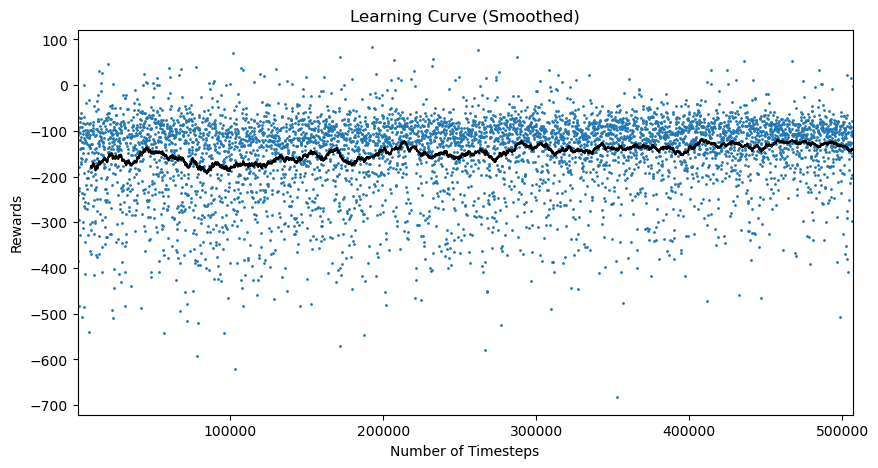

In [ ]:
model_dir = "../models/01_LunarLander/ppo-LunarLander-v2/"

env = make_vec_env("LunarLander-v2", n_envs=16, monitor_dir=model_dir)
model = PPO(
    policy="MlpPolicy",
    env=env,
    n_steps=512,
    batch_size=64,
    n_epochs=5,
#     clip_range=0.2, # Clipped Surrogate Objective
    ent_coef=3, # Fixed KL Penalty Coefficient
#     target_kl=0.1, # Adaptive KL Penalty Coefficient
    verbose=0,
    tensorboard_log="../tb_logs/"
)
callback = SaveOnBestTrainingRewardCallback(log_dir=model_dir)

model.learn(total_timesteps=500_000, callback=callback, tb_log_name="v2_2m")
plot_results(model_dir)

In [ ]:
agent_eval(model);

mean_mean=130.261, SEM=27.45299503931069, CI=[73.600:186.921]
mean_length=440.880, SEM=42.162041380053374, CI=[353.862:527.898]


In [ ]:
save_trained_agent_gif(model, filename="ppo_v2.gif", n=5, fps=60)
display(Markdown(f"<img src='ppo_v2.gif'>"))

<img src='ppo_v2.gif'>

### Adaptive KL Penalty Coefficient = 0.1

New best mean reward: -195.90, eval_episodes: 80, total_steps: 8192, total_episodes: 80
New best mean reward: -177.37, eval_episodes: 87, total_steps: 16384, total_episodes: 167
New best mean reward: -147.73, eval_episodes: 79, total_steps: 24576, total_episodes: 246
New best mean reward: -135.65, eval_episodes: 69, total_steps: 32768, total_episodes: 315
New best mean reward: -104.78, eval_episodes: 50, total_steps: 57344, total_episodes: 492
New best mean reward: -97.29, eval_episodes: 47, total_steps: 65536, total_episodes: 539
New best mean reward: -55.19, eval_episodes: 29, total_steps: 81920, total_episodes: 603
New best mean reward: -27.38, eval_episodes: 22, total_steps: 90112, total_episodes: 625
New best mean reward: -16.43, eval_episodes: 20, total_steps: 98304, total_episodes: 645
New best mean reward: -11.39, eval_episodes: 14, total_steps: 114688, total_episodes: 676
New best mean reward: 0.21, eval_episodes: 8, total_steps: 196608, total_episodes: 775
New best mean rewar

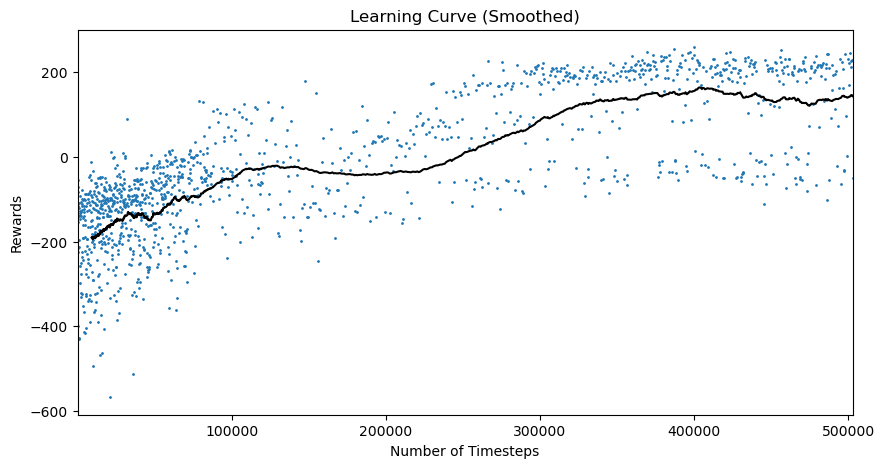

In [ ]:
model_dir = "../models/01_LunarLander/ppo-LunarLander-v2/"

env = make_vec_env("LunarLander-v2", n_envs=16, monitor_dir=model_dir)
model = PPO(
    policy="MlpPolicy",
    env=env,
    n_steps=512,
    batch_size=64,
    n_epochs=5,
#     clip_range=0.2, # Clipped Surrogate Objective
#     ent_coef=3, # Fixed KL Penalty Coefficient
    target_kl=0.1, # Adaptive KL Penalty Coefficient
    verbose=0,
    tensorboard_log="../tb_logs/"
)
callback = SaveOnBestTrainingRewardCallback(log_dir=model_dir)

model.learn(total_timesteps=500_000, callback=callback, tb_log_name="v2_2m")
plot_results(model_dir)

In [ ]:
agent_eval(model);

mean_mean=149.886, SEM=20.895742664887898, CI=[106.759:193.012]
mean_length=495.520, SEM=23.863509102113767, CI=[446.268:544.772]


In [ ]:
save_trained_agent_gif(model, filename="ppo_v3.gif", n=5, fps=60)
display(Markdown(f"<img src='ppo_v2.gif'>"))

<img src='ppo_v2.gif'>

# Analysis
Let's break down the terms you mentioned and analyze the results:

### Hyperparameters and Settings:
1. **Clipped Surrogate Objective:**
   - This is a technique used to stabilize training in policy gradient methods. The objective function is clipped to ensure that the update to the policy is not too large. The `clip_range=0.2` means that the surrogate objective is clipped at a maximum of 20% deviation from the old policy.

2. **Fixed KL Penalty Coefficient:**
   - In PPO, the objective function consists of two components: the policy loss and an entropy term. The entropy term is weighted by the entropy coefficient (`ent_coef`). The overall objective function is a combination of the policy loss and the entropy term, and it is designed to balance between maximizing the expected return (policy loss) and encouraging exploration (entropy term).

3. **Adaptive KL Penalty Coefficient:**
   - The `target_kl` is the target KL divergence between the old and new policies. If the actual KL divergence exceeds this value, it adjusts the penalty to bring it back within bounds. This is a form of dynamically adjusting the strength of the regularization term.

### Metrics:

1. **Mean:**
   - **Mean Mean Reward:** The average (mean) of the rewards obtained by the agent over a set of evaluation episodes. It provides an overall measure of the agent's performance.

   - **Mean Mean Episode Length:** The average (mean) duration (length) of episodes over a set of evaluation episodes. It indicates how long, on average, the agent takes to complete an episode.

2. **SEM (Standard Error of the Mean):**
   - **SEM for Mean Reward:** The standard error of the mean for the rewards. It measures the precision of the sample mean and indicates how much the sample mean is expected to vary from the true population mean. A lower SEM suggests more precise estimates.

   - **SEM for Mean Episode Length:** The standard error of the mean for episode lengths. Similar to the reward SEM, it measures the precision of the estimate for the mean episode length.

3. **CI (Confidence Interval):**
   - **CI for Mean Reward:** The confidence interval for the mean reward. It provides a range within which we can reasonably expect the true population mean reward to fall. The narrower the interval, the more precise the estimate.

   - **CI for Mean Episode Length:** The confidence interval for the mean episode length. Similar to the reward CI, it provides a range within which we can reasonably expect the true population mean episode length to fall.


### Analysis:
1. **Clipped Surrogate Objective:**
   - The results show a gradual improvement in mean reward over time. The clipped surrogate objective helps in preventing large policy updates, contributing to a more stable learning process.

2. **Fixed KL Penalty Coefficient:**
   - The results exhibit a fluctuating pattern in mean reward. The fixed penalty may be too strong in some cases, hindering the exploration-exploitation balance.

3. **Adaptive KL Penalty Coefficient:**
   - The results show a more stable and consistent improvement in mean reward. The adaptive penalty allows for a more flexible adjustment, contributing to better exploration and convergence.



### Overall Analysis:
- The fixed KL penalty setting appears to be more consistent, as evidenced by lower SEM values and narrower confidence intervals. This indicates that the fixed KL penalty may provide a more reliable and stable training process compared to the adaptive KL penalty.

- While the adaptive KL penalty setting might explore more (as seen in longer episode lengths), the increased variability in mean reward and episode length suggests that it might not consistently outperform the fixed KL penalty setting.
- The adaptive KL penalty seems to offer a good balance, providing stability similar to the clipped surrogate while dynamically adjusting to the training progress.
- The fixed KL penalty may require careful tuning to find an optimal strength.
- The clipped surrogate and adaptive KL penalty share the advantage of adaptability, contributing to more robust training dynamics.


## Adaptive Clip

To adaptively determine the value of ϵ (clip_range) during training, you can use a technique called "Adaptive Clip Range" where you adjust the clip_range based on the performance of the policy. One common approach is to monitor the KL divergence between the new and old policies and adjust the clip_range to keep the KL divergence close to a target value.

New best mean reward: -156.57, eval_episodes: 82, total_steps: 8192, total_episodes: 82
New best mean reward: -142.17, eval_episodes: 85, total_steps: 16384, total_episodes: 167
New best mean reward: -129.24, eval_episodes: 81, total_steps: 24576, total_episodes: 248
New best mean reward: -127.76, eval_episodes: 77, total_steps: 32768, total_episodes: 325
New best mean reward: -115.04, eval_episodes: 69, total_steps: 40960, total_episodes: 394
New best mean reward: -109.06, eval_episodes: 61, total_steps: 49152, total_episodes: 455
New best mean reward: -69.33, eval_episodes: 53, total_steps: 57344, total_episodes: 508
New best mean reward: -46.26, eval_episodes: 41, total_steps: 73728, total_episodes: 590
New best mean reward: -42.51, eval_episodes: 25, total_steps: 81920, total_episodes: 615
New best mean reward: -26.09, eval_episodes: 14, total_steps: 90112, total_episodes: 629
New best mean reward: 53.55, eval_episodes: 10, total_steps: 106496, total_episodes: 652
New best mean rew

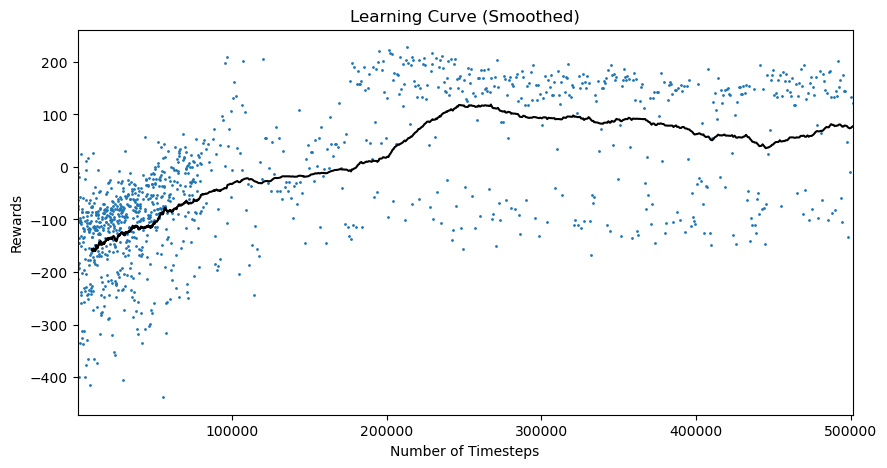

In [ ]:
def clip_scheduler(progress):
    """
    Clipping parameter schedule for PPO.
    :param progress: (float) Progress will decrease from 1 (beginning) to 0.
    :return: (float) Clipping parameter
    """
    clip_param = 0.2  # Default initial value
#     print(progress)
    if progress < 0.85:
        clip_param = 0.5
    if progress < 0.66:
        clip_param = 0.3
    if progress < 0.33:
        clip_param = 0.1

    return clip_param

# Modify your PPO training code to use the clip range scheduler
model_dir = "../models/01_LunarLander/ppo-LunarLander-v2/"

env = make_vec_env("LunarLander-v2", n_envs=16, monitor_dir=model_dir)
model = PPO(
    policy="MlpPolicy",
    env=env,
    n_steps=512,
    batch_size=64,
    n_epochs=5,
    clip_range=clip_scheduler,
    target_kl=0.1, # Adaptive KL Penalty Coefficient
    verbose=0,
    tensorboard_log="../tb_logs/"
)
callback = SaveOnBestTrainingRewardCallback(log_dir=model_dir)

model.learn(total_timesteps=500_000, callback=callback, tb_log_name="v2_2m")
plot_results(model_dir)


In [ ]:
agent_eval(model)


mean_mean=25.325, SEM=17.38510585281488, CI=[-10.556:61.206]
mean_length=921.440, SEM=24.045725884932924, CI=[871.812:971.068]


25.325099599999998

In [ ]:
save_trained_agent_gif(model, filename="ppo_v2.gif", n=5, fps=60)
display(Markdown(f"<img src='ppo_v2.gif'>"))

<img src='ppo_v2.gif'>

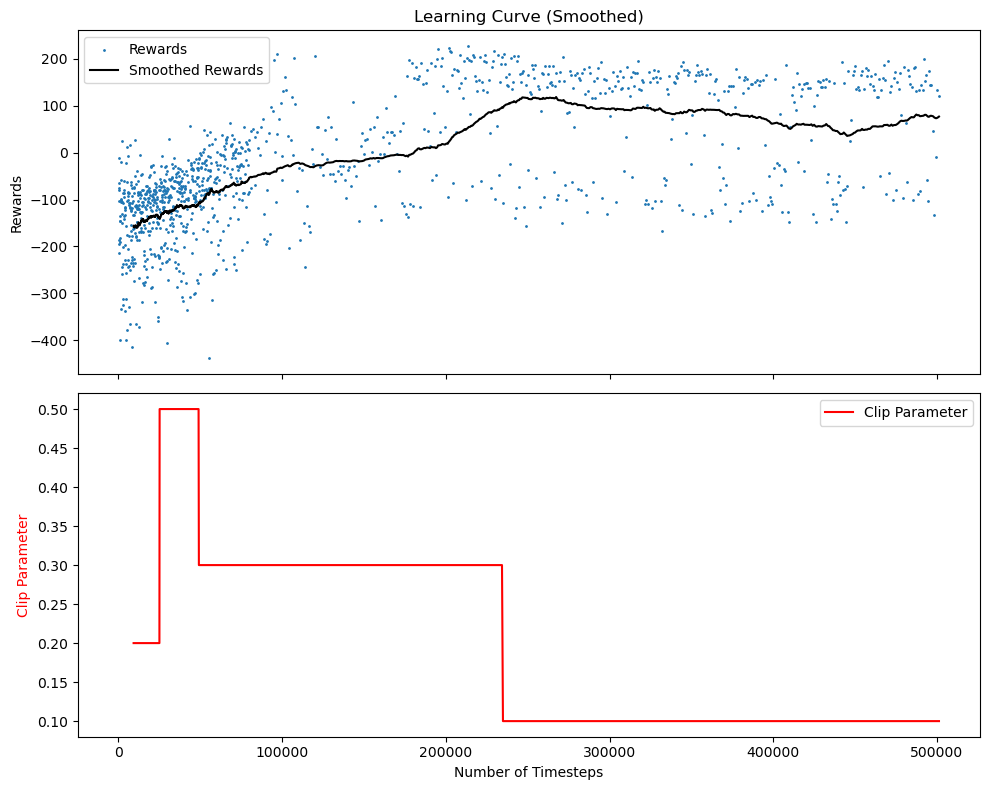

In [ ]:
from stable_baselines3.common.results_plotter import load_results, ts2xy

def plot_results(log_folder, title='Learning Curve'):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

    x, y = ts2xy(load_results(log_folder), 'timesteps')
    min_x, max_x = min(x), max(x)

    # Plot rewards
    ax1.scatter(x, y, s=1, label='Rewards')
    y = moving_average(y, window=100)
    x = x[len(x) - len(y):]
    ax1.plot(x, y, color="black", label="Smoothed Rewards")
    ax1.set_ylabel('Rewards')
    ax1.set_title(title + " (Smoothed)")
    ax1.legend()

    # Plot clip values
    progress_values = np.linspace(1, 0, len(x))  # Assuming progress decreases from 1 to 0
    clip_values = [clip_scheduler(progress) for progress in progress_values]
    ax2.plot(x, clip_values, color="red", label="Clip Parameter")
    ax2.set_xlabel('Number of Timesteps')
    ax2.set_ylabel('Clip Parameter', color="red")
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Usage
plot_results(model_dir)


If the clip parameter is larger, it allows for larger policy updates. This can be beneficial in the early stages of training or when exploration is desired. A larger clip parameter allows for more significant changes in the policy, potentially leading to more exploration of the action space.  On the other hand, a smaller clip parameter restricts the policy update to be closer to the old policy. This can be useful when the policy is already close to optimal, and you want to make more conservative updates to avoid destabilizing the training. So we define a scheduler to reduce the `clip_range` as the agent learns.
we can see that the agent reach higher reward sooner and the final reward is higher too.